In [2]:
# Demonstrate how model complexity influences both prediction accuracy and computational performance.

# http://scikit-learn.org/stable/auto_examples/applications/plot_model_complexity_influence.html

# The dataset is the Boston Housing dataset (resp. 20 Newsgroups) for regression (resp. classification).

# For each class of models we make the model complexity vary through the choice of relevant model parameters 
# and measure the influence on both computational performance (latency) and predictive power (MSE or Hamming Loss).

In [3]:
%matplotlib inline
# import necessary libraries and specify that graphs should be plotted inline. 
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.parasite_axes import host_subplot
from mpl_toolkits.axisartist.axislines import Axes
from scipy.sparse.csr import csr_matrix

from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.svm.classes import NuSVR
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.metrics import hamming_loss

# initialize random generator
np.random.seed(0)

In [4]:
def generate_data(case, sparse=False):
    """Generate regression/classification data."""
    bunch = None
    if case == 'regression':
        bunch = datasets.load_boston()
    elif case == 'classification':
        bunch = datasets.fetch_20newsgroups_vectorized(subset='all')
    X, y = shuffle(bunch.data, bunch.target)
    offset = int(X.shape[0] * 0.8)
    X_train, y_train = X[:offset], y[:offset]
    X_test, y_test = X[offset:], y[offset:]
    if sparse:
        X_train = csr_matrix(X_train)
        X_test = csr_matrix(X_test)
    else:
        X_train = np.array(X_train)
        X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_train = np.array(y_train)
    data = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train,
            'y_test': y_test}
    return data

In [5]:
def benchmark_influence(conf):
    """
    Benchmark influence of :changing_param: on both MSE and latency.
    """
    prediction_times = []
    prediction_powers = []
    complexities = []
    for param_value in conf['changing_param_values']:
        conf['tuned_params'][conf['changing_param']] = param_value
        estimator = conf['estimator'](**conf['tuned_params'])
        print("Benchmarking %s" % estimator)
        estimator.fit(conf['data']['X_train'], conf['data']['y_train'])
        conf['postfit_hook'](estimator)
        complexity = conf['complexity_computer'](estimator)
        complexities.append(complexity)
        start_time = time.time()
        for _ in range(conf['n_samples']):
            y_pred = estimator.predict(conf['data']['X_test'])
        elapsed_time = (time.time() - start_time) / float(conf['n_samples'])
        prediction_times.append(elapsed_time)
        pred_score = conf['prediction_performance_computer'](
            conf['data']['y_test'], y_pred)
        prediction_powers.append(pred_score)
        print("Complexity: %d | %s: %.4f | Pred. Time: %fs\n" % (
            complexity, conf['prediction_performance_label'], pred_score,
            elapsed_time))
    return prediction_powers, prediction_times, complexities


def plot_influence(conf, mse_values, prediction_times, complexities):
    """
    Plot influence of model complexity on both accuracy and latency.
    """
    plt.figure(figsize=(12, 6))
    host = host_subplot(111, axes_class=Axes)
    plt.subplots_adjust(right=0.75)
    par1 = host.twinx()
    host.set_xlabel('Model Complexity (%s)' % conf['complexity_label'])
    y1_label = conf['prediction_performance_label']
    y2_label = "Time (s)"
    host.set_ylabel(y1_label)
    par1.set_ylabel(y2_label)
    p1, = host.plot(complexities, mse_values, 'b-', label="prediction error")
    p2, = par1.plot(complexities, prediction_times, 'r-',
                    label="latency")
    host.legend(loc='upper right')
    host.axis["left"].label.set_color(p1.get_color())
    par1.axis["right"].label.set_color(p2.get_color())
    plt.title('Influence of Model Complexity - %s' % conf['estimator'].__name__)
    plt.show()

Benchmarking SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.25,
       learning_rate='optimal', loss='modified_huber', n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
Complexity: 4454 | Hamming Loss (Misclassification Ratio): 0.2501 | Pred. Time: 0.024233s

Benchmarking SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.5, learning_rate='optimal',
       loss='modified_huber', n_iter=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5, random_state=None, shuffle=True, verbose=0,
       warm_start=False)
Complexity: 1624 | Hamming Loss (Misclassification Ratio): 0.2923 | Pred. Time: 0.019100s

Benchmarking SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.75,
       learning_rate='optimal'

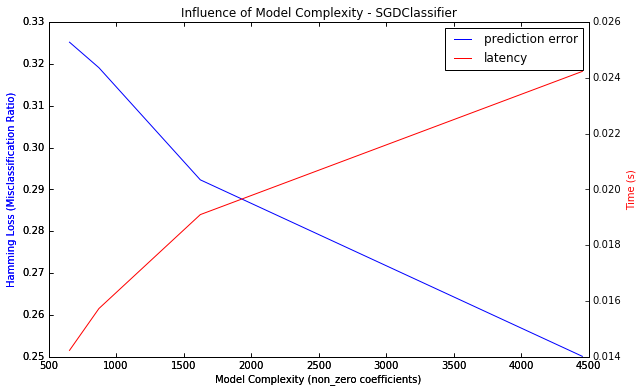

Benchmarking NuSVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, gamma=3.0517578125e-05,
   kernel='rbf', max_iter=-1, nu=0.1, shrinking=True, tol=0.001,
   verbose=False)
Complexity: 69 | MSE: 31.8133 | Pred. Time: 0.000333s

Benchmarking NuSVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, gamma=3.0517578125e-05,
   kernel='rbf', max_iter=-1, nu=0.25, shrinking=True, tol=0.001,
   verbose=False)
Complexity: 136 | MSE: 25.6140 | Pred. Time: 0.000500s

Benchmarking NuSVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, gamma=3.0517578125e-05,
   kernel='rbf', max_iter=-1, nu=0.5, shrinking=True, tol=0.001,
   verbose=False)
Complexity: 243 | MSE: 22.3315 | Pred. Time: 0.000833s

Benchmarking NuSVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, gamma=3.0517578125e-05,
   kernel='rbf', max_iter=-1, nu=0.75, shrinking=True, tol=0.001,
   verbose=False)
Complexity: 350 | MSE: 21.3679 | Pred. Time: 0.001167s

Benchmarking NuSVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, gamma=3.051757812

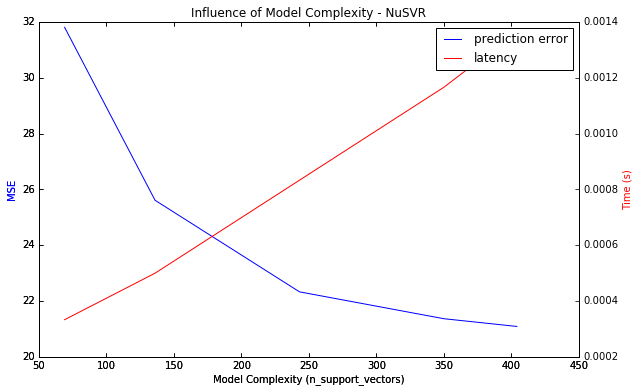

Benchmarking GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, presort='auto',
             random_state=None, subsample=1.0, verbose=0, warm_start=False)
Complexity: 10 | MSE: 28.9793 | Pred. Time: 0.000067s

Benchmarking GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=50, presort='auto',
             random_state=None, subsample=1.0, verbose=0, warm_start=False)
Complexity: 50 | MSE: 8.3398 | Pred. Time: 0.000167s

Benchmarking GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
        

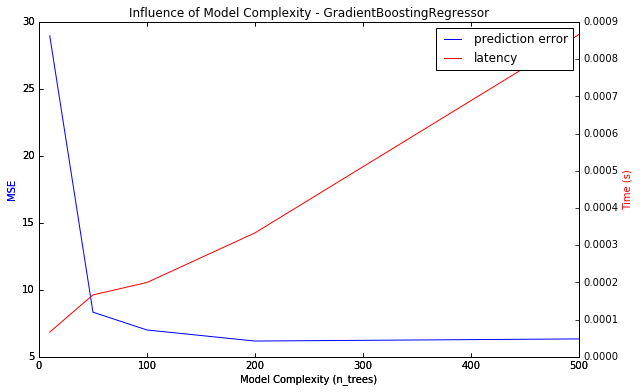

In [6]:
def _count_nonzero_coefficients(estimator):
    a = estimator.coef_.toarray()
    return np.count_nonzero(a)

# main code
regression_data = generate_data('regression')
classification_data = generate_data('classification', sparse=True)
configurations = [
    {'estimator': SGDClassifier,
     'tuned_params': {'penalty': 'elasticnet', 'alpha': 0.001, 'loss':
                      'modified_huber', 'fit_intercept': True},
     'changing_param': 'l1_ratio',
     'changing_param_values': [0.25, 0.5, 0.75, 0.9],
     'complexity_label': 'non_zero coefficients',
     'complexity_computer': _count_nonzero_coefficients,
     'prediction_performance_computer': hamming_loss,
     'prediction_performance_label': 'Hamming Loss (Misclassification Ratio)',
     'postfit_hook': lambda x: x.sparsify(),
     'data': classification_data,
     'n_samples': 30},
    {'estimator': NuSVR,
     'tuned_params': {'C': 1e3, 'gamma': 2 ** -15},
     'changing_param': 'nu',
     'changing_param_values': [0.1, 0.25, 0.5, 0.75, 0.9],
     'complexity_label': 'n_support_vectors',
     'complexity_computer': lambda x: len(x.support_vectors_),
     'data': regression_data,
     'postfit_hook': lambda x: x,
     'prediction_performance_computer': mean_squared_error,
     'prediction_performance_label': 'MSE',
     'n_samples': 30},
    {'estimator': GradientBoostingRegressor,
     'tuned_params': {'loss': 'ls'},
     'changing_param': 'n_estimators',
     'changing_param_values': [10, 50, 100, 200, 500],
     'complexity_label': 'n_trees',
     'complexity_computer': lambda x: x.n_estimators,
     'data': regression_data,
     'postfit_hook': lambda x: x,
     'prediction_performance_computer': mean_squared_error,
     'prediction_performance_label': 'MSE',
     'n_samples': 30},
]

for conf in configurations:
    prediction_performances, prediction_times, complexities = \
        benchmark_influence(conf)
    plot_influence(conf, prediction_performances, prediction_times,
                   complexities)